In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor


In [ ]:
df=pd.read_csv('MergedData.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')


In [ ]:
model1_features = [
    "temperature_2m", "relative_humidity_2m", "wind_speed_10m", "surface_pressure",
    "precipitation",
    "pm2_5_lag1", "pm2_5_lag7",
    "pm2_5_ma7", "pm2_5_ma14",
    "sin_doy", "cos_doy"
]
target="pm2_5"
print(df[model1_features + [target]].describe().T[['mean','std','min','max']])

                            mean        std         min         max
temperature_2m         23.654602   2.295012   18.749098   31.656734
relative_humidity_2m   70.301432  14.834035   29.743100   95.510790
wind_speed_10m         12.342990   4.726214    3.553789   27.019400
surface_pressure      912.862666   2.454833  906.857540  918.778900
precipitation          15.990390  30.324253    0.000000  246.800000
pm2_5_lag1             19.751811  12.503960    2.000000   63.300000
pm2_5_lag7             19.540947  12.434843    2.000000   63.300000
pm2_5_ma7              19.678770  10.811256    2.657143   52.985714
pm2_5_ma14             19.594399   9.888774    3.271429   40.507143
sin_doy                 0.011505   0.708236   -0.999991    0.999991
cos_doy                -0.012559   0.706757   -0.999963    1.000000
pm2_5                  19.787047  12.514625    2.000000   63.300000


In [ ]:
X = df[model1_features].values
y = df[target].values

# Hold out last 10% for final validation
holdout_n = max(1, int(0.1 * len(df)))
X_trainval, X_hold = X[:-holdout_n], X[-holdout_n:]
y_trainval, y_hold = y[:-holdout_n], y[-holdout_n:]
print("Train+CV rows:", len(X_trainval), "Holdout rows:", len(X_hold))


Train+CV rows: 647 Holdout rows: 71


In [ ]:
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
tscv = TimeSeriesSplit(n_splits=5)
train_idx, val_idx= list(tscv.split(X_trainval))[-1]
X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
y_train, y_val = y_trainval[train_idx], y_trainval[val_idx] 

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, 
                     subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',
                     random_state=42, verbosity=0, early_stopping_rounds=50)

model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          
          verbose=False)
pred=model.predict(X_val)
print("MAE", mean_absolute_error(y_val, pred))
print("RMSE", root_mean_squared_error(y_val, pred))

MAE 1.4351985819985933
RMSE 2.090816562503857


In [ ]:
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
maes,rmses=[],[]

for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx] 

    m = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, 
                     subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',
                     random_state=42, verbosity=0,
                      early_stopping_rounds=50)

    m.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
         
          verbose=False)
    pred=m.predict(X_val)
    mae=mean_absolute_error(y_val, pred)
    rmse=root_mean_squared_error(y_val, pred)
    maes.append(mae)
    rmses.append(rmse)
    print(f"Fold {i+1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Fold 1 - MAE: 5.7747, RMSE: 6.7236
Fold 2 - MAE: 2.7418, RMSE: 3.6962
Fold 3 - MAE: 8.0209, RMSE: 10.5105
Fold 4 - MAE: 5.4419, RMSE: 7.1456
Fold 5 - MAE: 1.4352, RMSE: 2.0908


In [ ]:
final=XGBRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, 
                     subsample=0.6, colsample_bytree=0.6, objective='reg:squarederror',
                     random_state=42, verbosity=0, early_stopping_rounds=50)
final.fit(X_trainval, y_trainval, 
          eval_set=[(X_hold, y_hold)],verbose=True)
pred_hold=final.predict(X_hold)
print("Final Holdout MAE:", mean_absolute_error(y_hold, pred_hold))
print("Final Holdout RMSE:", root_mean_squared_error(y_hold, pred_hold))

[0]	validation_0-rmse:10.79749
[1]	validation_0-rmse:10.35385
[2]	validation_0-rmse:9.93791
[3]	validation_0-rmse:9.59486
[4]	validation_0-rmse:9.25753
[5]	validation_0-rmse:8.85568
[6]	validation_0-rmse:8.53231
[7]	validation_0-rmse:8.21775
[8]	validation_0-rmse:7.93141
[9]	validation_0-rmse:7.67535
[10]	validation_0-rmse:7.41019
[11]	validation_0-rmse:7.17660
[12]	validation_0-rmse:6.96031
[13]	validation_0-rmse:6.78179
[14]	validation_0-rmse:6.59120
[15]	validation_0-rmse:6.43914
[16]	validation_0-rmse:6.25313
[17]	validation_0-rmse:6.24698
[18]	validation_0-rmse:6.08649
[19]	validation_0-rmse:5.92638
[20]	validation_0-rmse:5.77922
[21]	validation_0-rmse:5.64045
[22]	validation_0-rmse:5.55676
[23]	validation_0-rmse:5.46892
[24]	validation_0-rmse:5.36588
[25]	validation_0-rmse:5.30338
[26]	validation_0-rmse:5.23915
[27]	validation_0-rmse:5.17455
[28]	validation_0-rmse:5.10781
[29]	validation_0-rmse:5.03576
[30]	validation_0-rmse:5.00265
[31]	validation_0-rmse:4.94816
[32]	validation_

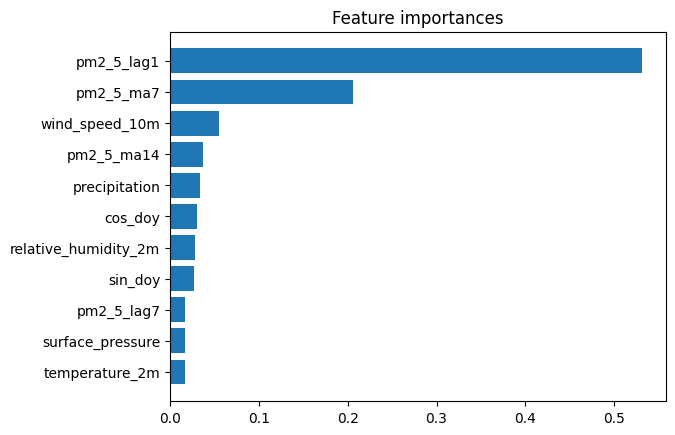

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = final.feature_importances_
idx = np.argsort(importances)[::-1]
plt.barh(np.array(model1_features)[idx], importances[idx])
plt.gca().invert_yaxis()
plt.title("Feature importances")
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "n_estimators": [200, 500, 800],
    "max_depth": [3, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
rs = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0),
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs.fit(X_trainval, y_trainval)   # NOTE: no early stopping here (search simplicity)
print("Best params:", rs.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


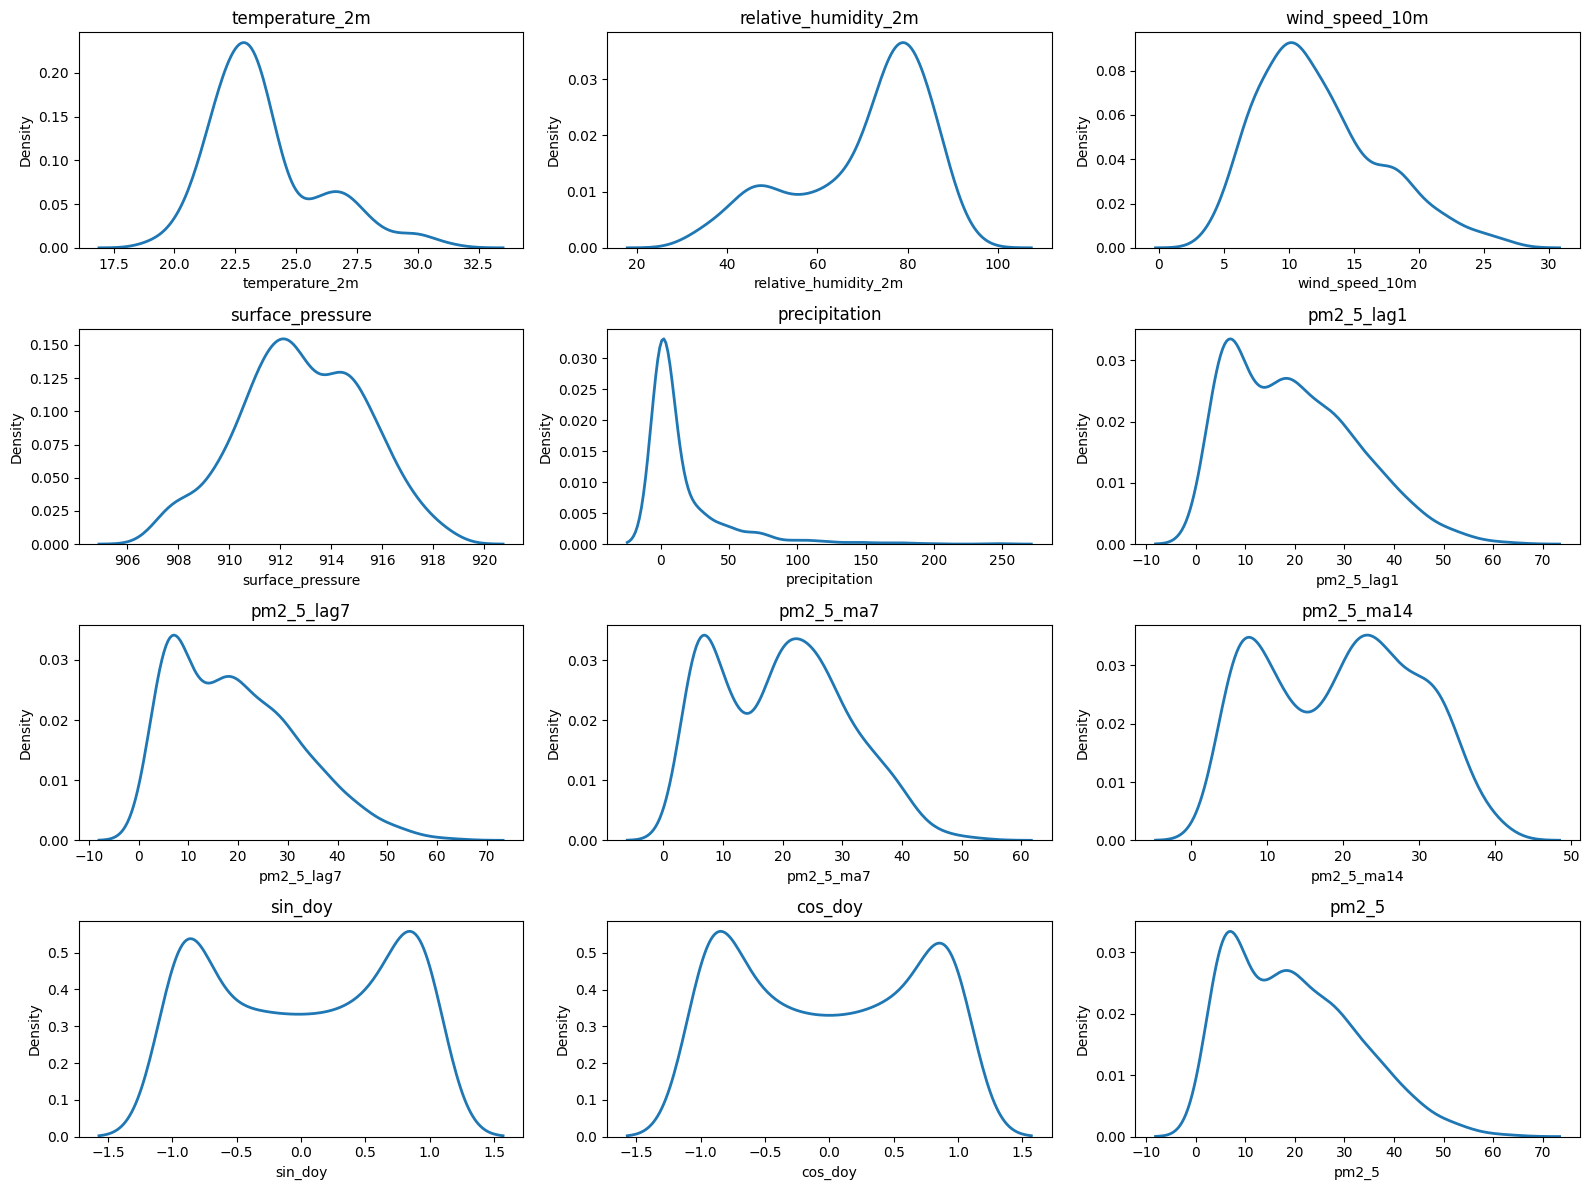

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = model1_features + ['pm2_5']   # include target if you want

plt.figure(figsize=(16, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4,3, i)  # Adjust rows/cols depending on number of features
    sns.kdeplot(df[col], linewidth=2)
    plt.title(col)
    plt.tight_layout()

plt.show()


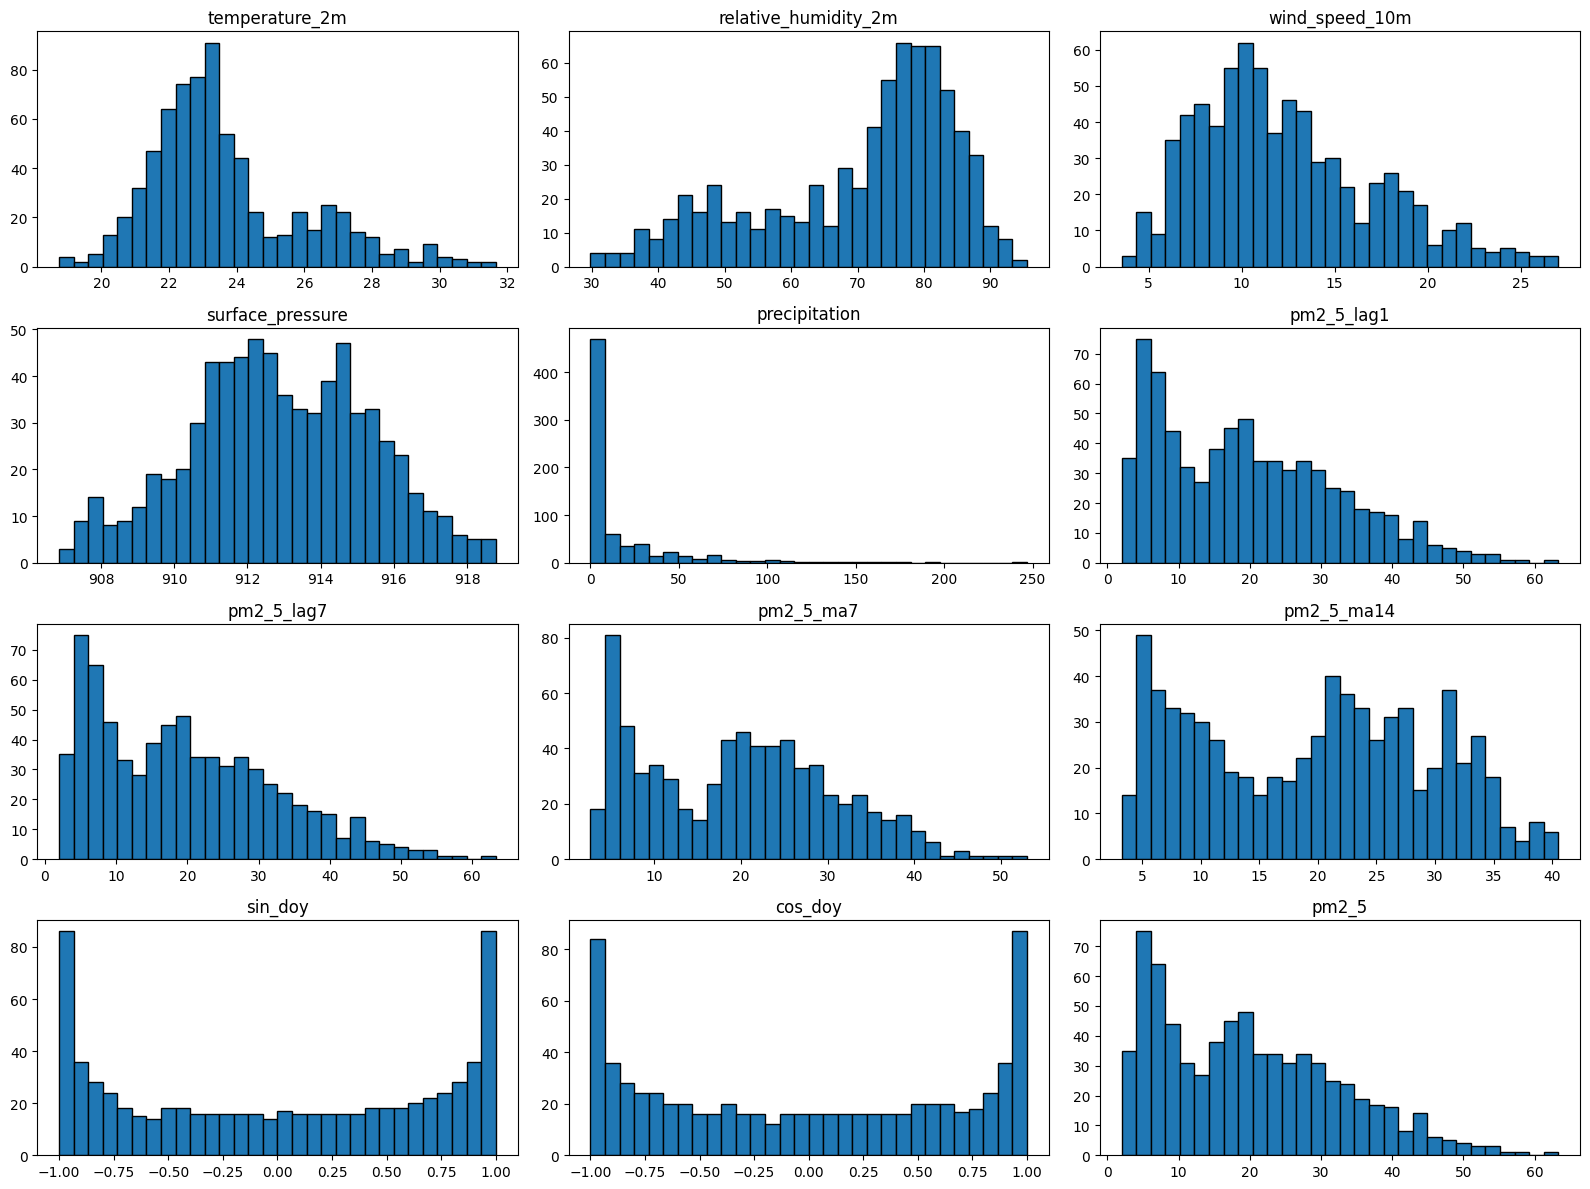

In [ ]:
import matplotlib.pyplot as plt

cols = model1_features + ['pm2_5']   # all features + target

plt.figure(figsize=(16, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 3, i)  # Adjust grid size depending on number of features
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()


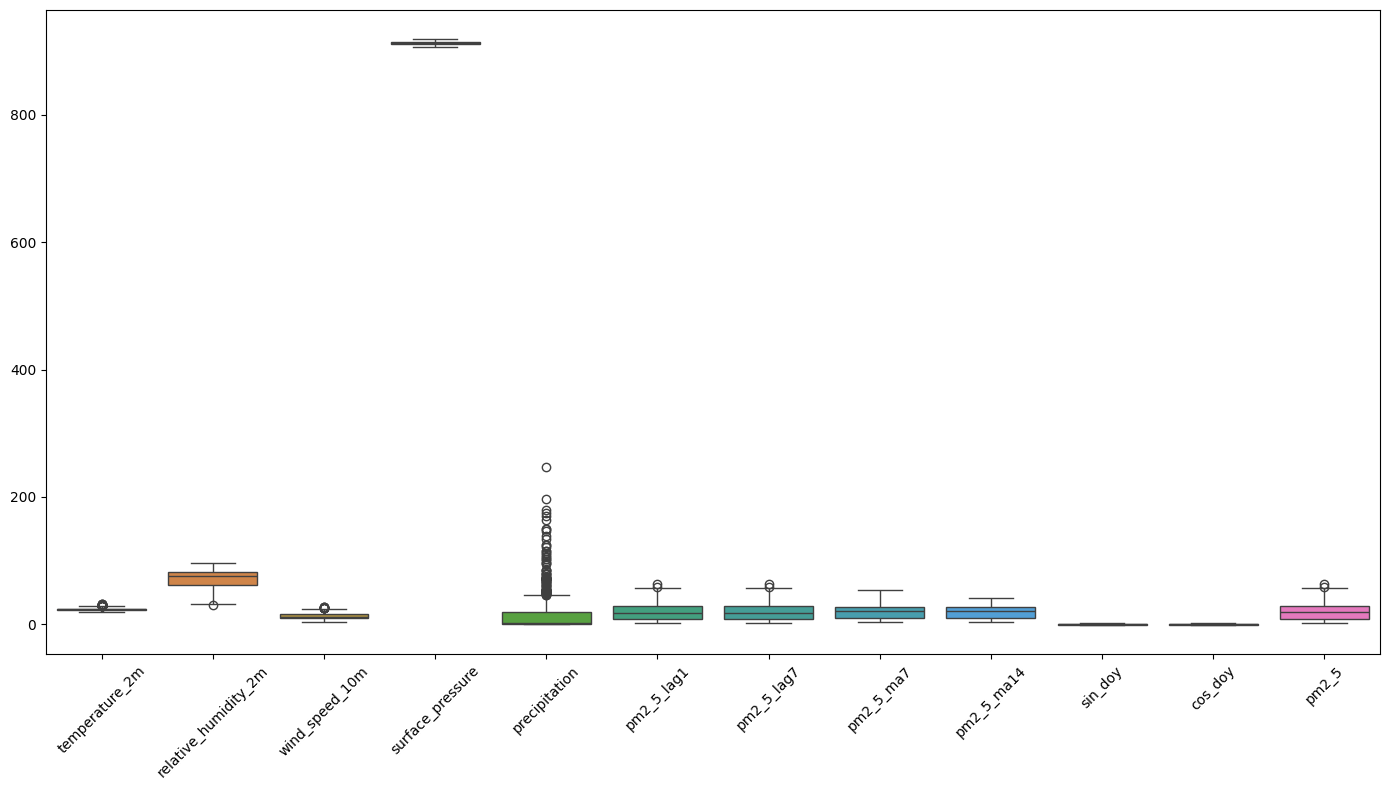

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))
sns.boxplot(data=df[model1_features + ['pm2_5']])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   718 non-null    datetime64[ns]
 1   temperature_2m         718 non-null    float64       
 2   relative_humidity_2m   718 non-null    float64       
 3   wind_speed_10m         718 non-null    float64       
 4   surface_pressure       718 non-null    float64       
 5   precipitation          718 non-null    float64       
 6   pm10                   718 non-null    float64       
 7   pm2_5                  718 non-null    float64       
 8   carbon_monoxide        718 non-null    float64       
 9   nitrogen_dioxide       718 non-null    float64       
 10  sulphur_dioxide        718 non-null    float64       
 11  ozone                  718 non-null    float64       
 12  dayofyear              718 non-null    int64         
 13  sin_d

In [ ]:
cols=df.columns.difference(['date'])
print(df[df[cols] < 0])

    date  temperature_2m  relative_humidity_2m  wind_speed_10m  \
0    NaT             NaN                   NaN             NaN   
1    NaT             NaN                   NaN             NaN   
2    NaT             NaN                   NaN             NaN   
3    NaT             NaN                   NaN             NaN   
4    NaT             NaN                   NaN             NaN   
..   ...             ...                   ...             ...   
713  NaT             NaN                   NaN             NaN   
714  NaT             NaN                   NaN             NaN   
715  NaT             NaN                   NaN             NaN   
716  NaT             NaN                   NaN             NaN   
717  NaT             NaN                   NaN             NaN   

     surface_pressure  precipitation  pm10  pm2_5  carbon_monoxide  \
0                 NaN            NaN   NaN    NaN              NaN   
1                 NaN            NaN   NaN    NaN              NaN 

In [ ]:
final.save_model("model2_xgb.json")


In [ ]:
import xgboost as xgb
m = xgb.XGBRegressor()
m.load_model("model2_xgb.json")

In [ ]:
p = m.predict(X_hold)
print(mean_absolute_error(y_hold, p))
print(root_mean_squared_error(y_hold, p))

3.087331179497947
4.094766694028811


In [ ]:
row = df.loc[650]
x = row[model1_features].values.reshape(1, -1)
pred = m.predict(x)
print(pred)
print(row[target])

[15.066157]
17.6


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("Model 2 MAE:", mean_absolute_error(y_hold, p))
print("Model 2 RMSE:", root_mean_squared_error(y_hold, p))

Model 2 MAE: 3.087331179497947
Model 2 RMSE: 4.094766694028811


In [ ]:
compare = pd.DataFrame({
    "date": df["date"].iloc[-len(y_hold):].values,
    "actual": y_hold,
    "model2_pred": p,})
compare["model2_abs_error"] = (compare["actual"] - compare["model2_pred"]).abs()
compare

,date,actual,model2_pred,model2_abs_error
0,2025-09-05,9.5,8.910330,0.589670
1,2025-09-06,9.9,12.159759,2.259759
2,2025-09-07,9.8,10.773527,0.973527
3,2025-09-08,17.6,15.066157,2.533843
4,2025-09-09,28.2,23.632469,4.567531
...,...,...,...,...
66,2025-11-10,37.6,40.485687,2.885687
67,2025-11-11,41.4,38.324593,3.075407
68,2025-11-12,40.8,38.618443,2.181557
69,2025-11-13,33.8,37.392998,3.592998
